# Reliability - Proof of Concept on a simulated dataset
In this notebook I show how we can study the reliability problem.


Recall that reliability is not focused on the overrall accuracy of a model
on a test set, it is rather focused on assessing how much reliable is
a prediction on a new unseen example (**Can we trust this prediction?**) .


Recall also that a "reliable" system should satisfy two principles:

- the local density principle: "how much my new example is similar
to instances of the training set?"
- the local fit principle: "how is my model accurate on the most similar examples of the 
training set?"

We face the reliability problem by using an approach for training instance selection. Instance selection
methods select the most relevant instances in order to reduce the number of examples of the training set. By
retaining only the non-redundant and informative examples, these approaches are used to decrease
the computational time of algorithms such as k-Nearest Neighbor without reducing the accuracy 
performance [2].

The idea is that if a new unseen example $x$ would be selected by one of such methods as an "important" instance in comparison with
the available training set, 
then the prediction made by a model not trained on $x$ is not completely reliable,
since the unseen instance is adding information to the training set.

To do so, we use of the approach proposed by [3], where authors introduce the concept of 
"border" instances: for a given attribute, a training example is "border" if, 
among the training examples of the
same classes, it is the nearest example to another example of the other classes. The *weakness* of an instance is the number 
of times that that instance is border in a partition over the 
attributes. If $weakness(x)=m$, where $m$ is the number of attributes, then $x$ is not in the border for any of the
$m$ attributes. This approach is called patterns by ordered projections (POP).

We used POP *a posteriori*: i.e., when we have a new unseen example $x$, we check if $x$ would become
border for each attribute, by comparing $x$ with the borders of the training set.
Then, we defined the reliability as
$rel(x)=1-\frac{n_m}{m}$

where $n_m$ is the number of times that $x$ is border.

Previous works are model-specific, since thay include reliability in the modeling process [4],
while others compare the different in class probability distribution of two models, one 
trained without the new example and the other trained including the new example [5].

Instead, this approach can be applied after the training of any ML algorithms,
and it requires to compute 4*m metrics distances, instead of comparing the unseen example
with the entire training set.



In [1]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
from collections import Counter
from pop_implemetation import pop_instance_training, check_is_border
from utils import make_classification_adjusted
from sklearn.metrics import *

In [2]:
def create_plot(df_pl, colors = {0:'blue', 1:'red'}, title='', group_by='label'):
    fig, ax = pyplot.subplots()
    grouped = df_pl.groupby(group_by)
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    pyplot.title(title)
    pyplot.show()

First step: generate a simulated datasets with two classes, two attributes. 
We assume that the examples of the two classes may come from 4 different clusters with 
different shape, as shown in figure.

In [4]:
# Generate a simulated datasets with two classes
X, y, clusters = make_classification_adjusted(n_samples=6000, n_classes=2, n_features=2, n_informative=2,
                           n_redundant=0,
                           random_state=1, weights=np.array([0.8, 0.2]),
                           class_sep=0.7,
                           n_clusters_per_class=2, shuffle=False)

class_num = Counter(y)

Counter({0: 4785, 1: 1215})


As we can see, the dataset is highly unbalanced

In [5]:
print(class_num)

Counter({0: 4785, 1: 1215})


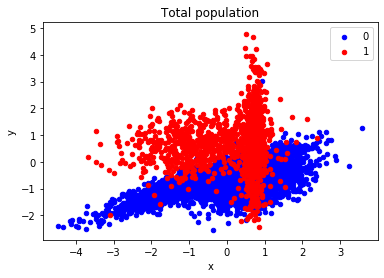

In [6]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y, clusters=clusters))
create_plot(df, title='Total population')

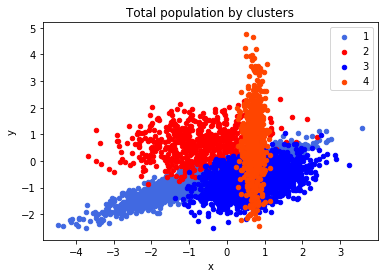

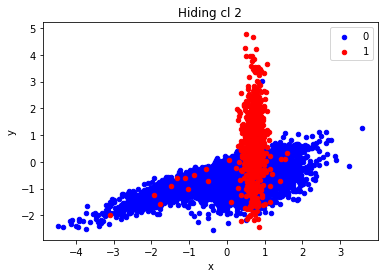

In [7]:
create_plot(df, title='Total population by clusters', group_by='clusters',
            colors={1: 'royalblue', 2: 'red', 3: 'blue', 4: 'orangered'})

We hide cluster #1

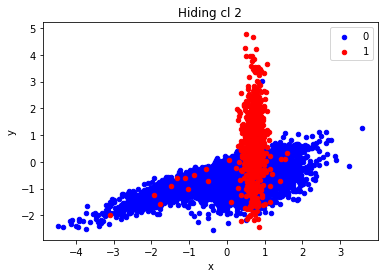

In [8]:
#"Hiding" cluster 1
create_plot(df[df['clusters'] != 2], title='Hiding cl 2')
iCl2 = np.where(df['clusters'] == 2)
iCl134 = np.where(df['clusters'] != 2)

We select a balanced dataset to simulate the fact the our training set is not
representative of the real population. The selected dataset will 
split into a balanced training and a balanced test set.

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(1)
rsize = round(Counter(y[iCl134])[1]*0.5)
bsize = rsize
iRedTrain = np.random.choice(np.where(y[iCl134]==1)[0], size=rsize, replace=False)
iBlueTrain = np.random.choice(np.where(y[iCl134]==0)[0], size=bsize, replace=False)


X_bal = X[iCl134][np.concatenate((iBlueTrain, iRedTrain))]
y_bal = y[iCl134][np.concatenate((iBlueTrain, iRedTrain))]
X_val = np.concatenate((X[iCl2], X[iCl134][[i for i in range(X[iCl134].shape[0]) if i not in np.concatenate((iBlueTrain, iRedTrain))]]))
y_val = np.concatenate((y[iCl2], y[iCl134][[i for i in range(X[iCl134].shape[0]) if i not in np.concatenate((iBlueTrain, iRedTrain))]]))

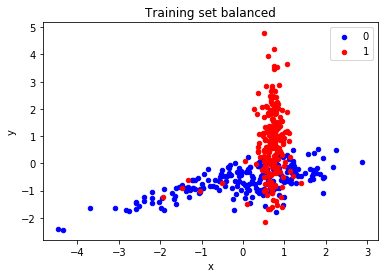

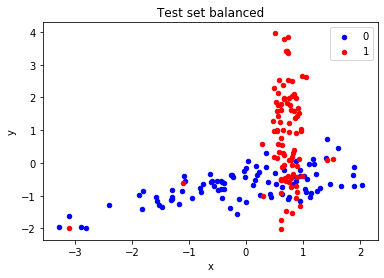

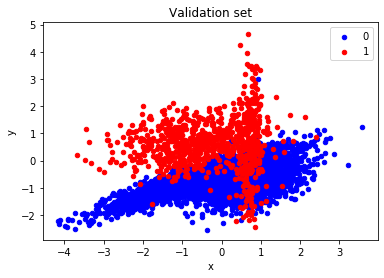

In [15]:
# Stratified selection for training and test
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal,
                                                                    y_bal,
                                                                    stratify=y_bal,
                                                                    random_state=1,
                                                                    test_size=0.3)

create_plot(pd.DataFrame(dict(x=X_train_bal[:, 0],
                              y=X_train_bal[:, 1], label=y_train_bal)),
            title='Training set balanced')
create_plot(pd.DataFrame(dict(x=X_test_bal[:, 0],
                              y=X_test_bal[:, 1], label=y_test_bal)),
            title='Test set balanced')
create_plot(pd.DataFrame(dict(x=X_val[:, 0],
                              y=X_val[:, 1], label=y_val)),
            title='Validation set')

We find the borders on the training set

In [16]:
# POP
(mind_train, maxd_train, isborder_train, attr2outerb_train, attr2innerb_train,
 attr2outerb_train_val, attr2innerb_train_val) = pop_instance_training(X_train_bal, y_train_bal)
train_border_examples = X_train_bal[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel(),:]
ytrain_border_examples = y_train_bal[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel()]

In [17]:
# Training a Support Vector Machine on the balanced dataset
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=1, tol=1e-10, max_iter=2000)
clf.fit(X_train_bal, y_train_bal)
ypred_test_bal = clf.predict(X_test_bal)


n_border_test = [0]*X_test_bal.shape[0]
for c in list(range(X_test_bal.shape[0])):
    #print(c)
    xtest = X_test_bal[c]
    bor = ''
    for i in range(X_test_bal.shape[1]):
        bor = bor + check_is_border(xtest[i], attr2outerb_train_val[i], inner=False)
        bor = bor + check_is_border(xtest[i], attr2outerb_train_val[i], inner=False)
        if 'Outer' in bor or 'Inner' in bor:
            n_border_test[c] = n_border_test[c]+1

In [18]:
# Reliability on the test set
rel_test = 1-np.array(n_border_test)/X_test_bal.shape[1]
unreliable_test = np.argwhere(rel_test==0).ravel()
reliable_test = np.argwhere(rel_test!=0).ravel() # or !=0

In [19]:
print('Number of instances in test set:'+str(X_test_bal.shape[0]))
print('Number of reliable instances in test set:'+str(len(reliable_test)))
print('Number of unreliable instances in test set:'+str(len(unreliable_test)))

Number of instances in test set:186
Number of reliable instances in test set:176
Number of unreliable instances in test set:10


Accuracy on reliable examples

In [20]:
acc_rel = accuracy_score(y_test_bal[reliable_test], ypred_test_bal[reliable_test])
print(acc_rel)

0.8011363636363636


Accuracy on non-reliable examples

In [21]:
print(accuracy_score(y_test_bal[unreliable_test], ypred_test_bal[unreliable_test]))

0.7


Accuracy on the complete test set

In [22]:
acc_test = accuracy_score(y_test_bal, ypred_test_bal)
print(accuracy_score(y_test_bal, ypred_test_bal))

0.7956989247311828


In [23]:
z=1.96
interval = z*np.sqrt(acc_test*(1-acc_test)/X_test_bal.shape[0])
conf_inf = [acc_test-interval, acc_test+interval]
print('95% Confidence intervals:'+str(conf_inf[0])+'-'+str(conf_inf[1]))

Confidence intervals:0.7377548128118339-0.8536430366505317


Note: the accuracy of the unreliable elements is outside the confidence interval

## Analysis on the Validation set
Now we evaluate prediction and reliability on the validation set

In [24]:
# Results on test set are pretty good! Here we see what happens when we consider the (true)
# balanced dataset
ypred_val = clf.predict(X_val)

acc_val = accuracy_score(y_val, ypred_val)
prec_val = precision_score(y_val, ypred_val) # Precision decrease a lot! (form 86% to 56%)
rec_val = recall_score(y_val, ypred_val)

tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, ypred_val).ravel()

In [25]:
## Reliability on Validation set
n_border_val = [0]*X_val.shape[0]
for c in list(range(X_val.shape[0])):
    # print(c)
    xval = X_val[c]
    bor = ''
    for i in range(X_val.shape[1]):
        bor = bor + check_is_border(xval[i], attr2outerb_train_val[i], inner=False)
        bor = bor + check_is_border(xval[i], attr2outerb_train_val[i], inner=False)
        if 'Outer' in bor or 'Inner' in bor:
            n_border_val[c] = n_border_val[c]+1

As we can see, classes are really unbalanced in the validation

In [26]:
Counter(y_val)

Counter({1: 905, 0: 4475})

In [27]:
rel_val = 1-np.array(n_border_val)/X_val.shape[1]
unreliable_val = np.argwhere(rel_val==0).ravel()
reliable_val = np.argwhere(rel_val==1).ravel() # or !=0

In [28]:
acc_unrel_val = accuracy_score(y_val[unreliable_val], ypred_val[unreliable_val])
prec_unrel_val = precision_score(y_val[unreliable_val], ypred_val[unreliable_val])
mcc_unrel_val = matthews_corrcoef(y_val[unreliable_val], ypred_val[unreliable_val])

acc_rel_val = accuracy_score(y_val[reliable_val], ypred_val[reliable_val])
prec_rel_val = precision_score(y_val[reliable_val], ypred_val[reliable_val])
mcc_rel_val = matthews_corrcoef(y_val[reliable_val], ypred_val[reliable_val])

acc_val = accuracy_score(y_val, ypred_val)
prec_val = precision_score(y_val, ypred_val)
mcc_val = matthews_corrcoef(y_val, ypred_val)

In [29]:
print('Number of elements in validation:'+str(X_val.shape[0]))
print('Number of reliable examples in validation:'+str(len(reliable_val)))
print('Number of unreliable examples in validation:'+str(len(unreliable_val)))

Number of elements in validation:5380
Number of reliable examples in validation:5004
Number of unreliable examples in validation:372


Performance on the validation

In [30]:
print('Accuracy on validation:'+str(acc_val))
print('Precision on validation:'+str(prec_val))
print('MCC on validation:'+str(mcc_val))

Accuracy on validation:0.8617100371747212
Precision on validation:0.5665839536807279
MCC on validation:0.5733757721484722


Performance on reliable examples of the validation

In [31]:
print('Accuracy on reliable validation:'+str(acc_rel_val))
print('Precision on reliable validation:'+str(prec_rel_val))
print('MCC on reliable validation:'+str(mcc_rel_val))

Accuracy on reliable validation:0.8852917665867306
Precision on reliable validation:0.655705996131528
MCC on reliable validation:0.6344713281080727


Performance on unreliable examples of the validation

In [32]:
print('Accuracy on unreliable validation:'+str(acc_unrel_val))
print('Precision on unreliable validation:'+str(prec_unrel_val))
print('MCC on unreliable validation:'+str(mcc_unrel_val))

Accuracy on unreliable validation:0.5456989247311828
Precision on unreliable validation:0.04
MCC on unreliable validation:0.12016518631918222


In [33]:
z=1.96
interval = z*np.sqrt(mcc_val*(1-mcc_val)/X_val.shape[0])
conf_inf = [mcc_val-interval, mcc_val+interval]
print('Confidence intervals for MCC on Validation:'+str(conf_inf[0])+'-'+str(conf_inf[1]))

Confidence intervals for MCC on Validation:0.5601595490824058-0.5865919952145386


In [34]:
z=1.96
interval = z*np.sqrt(prec_val*(1-prec_val)/X_val.shape[0])
conf_inf = [prec_val-interval, prec_val+interval]
print('Confidence intervals for Precision on Validation:'+str(conf_inf[0])+'-'+str(conf_inf[1]))

Confidence intervals for Precision on Validation:0.5533420763034527-0.5798258310580031


Also here we can note that that the MCC and the Precision of unreliable examples are
outside the confidence intervals of the mean computed over all the examples.

## References
[1] Tutorial: Safe and Reliable Machine Learning, Suchi Saria, Adarsh Subbaswamym, 2019
[2] Olvera-López, J.A., Carrasco-Ochoa, J.A., Martínez-Trinidad, 
J.F. et al. A review of instance selection methods. Artif Intell Rev 34, 133–143 (2010). https://doi.org/10.1007/s10462-010-9165-y
[3] Finding representative patterns with ordered projections, ose􏰀 C. Riquelme, Jesu􏰀s S. Aguilar-Ruiz, Miguel Toro, 2003
[4] Peter Schulam and Suchi Saria. 2019. Can you trust this prediction? Audit- ing Pointwise Reliability After Learning. In Artificial Intelligence and Statistics (AISTATS).
[5] M. Kukar, I. Kononenko, "Reliable Classifications with Machine Learning", Proc. 13th European Conf. Machine Learning, 2002